Notebook de test 

Attention, définitons manquantes

feedtable exclue

## Out-Of-Distribution (OOD) Robustness Testing

### Phase 1: Characterization of generated embedding & similarity measurement
Evaluate how far the generated embedding are close to each other. 

Plot a similarity matrix of the generated embedding to visualize the relationships between different products.

### Phase 2: OOD Robustness Testing on special cases (hypothesis testing)
Select one with the highest similarity score with one of the product in the training set and one with the lowest similarity score.

Evaluate the performance of the model on these two products when they are excluded from the training set.

Visualize the prediction vs the actual values for these two products.

In [9]:
import sys
sys.path.insert(0, '../')

import numpy as np
import pandas as pd
from sentence_transformers import util
from sklearn.metrics.pairwise import cosine_similarity
from src.data import load_data_excel 

embeddings_index = pd.read_excel('../data/data_with_embeddings_index.xlsx') 
embeddings = np.load('../data/embeddings_unique.npy')
embeddings.shape

(261, 768)

In [10]:
embeddings_index = embeddings_index[['Nom', 'embedding_idx', 'Definition', 'source']]
embeddings_index.drop_duplicates(inplace=True)

# Filtrer DataFrame
embeddings_index = embeddings_index[
    (embeddings_index['source'] != 'Feedtable') &
    (embeddings_index['Definition'].notna())
].reset_index(drop=True)

# Filtrer les embeddings correspondants
embeddings = embeddings[embeddings_index['embedding_idx'].values]

# Réassigner des indices propres
embeddings_index['embedding_idx'] = embeddings_index.index

# Créer le mapping Nom -> embedding
nom_to_embedding = dict(zip(embeddings_index['Nom'], embeddings))

# Vérification
print(embeddings.shape)



(67, 768)


In [11]:
# Mapping embedding_idx from embeddings_index to the corresponding embedding in embeddings
nom_to_embedding = dict(zip(
    embeddings_index['Nom'],
    embeddings[embeddings_index['embedding_idx']]
))

In [12]:
similarity_matrix = cosine_similarity(embeddings)
similarity_matrix.shape

(67, 67)

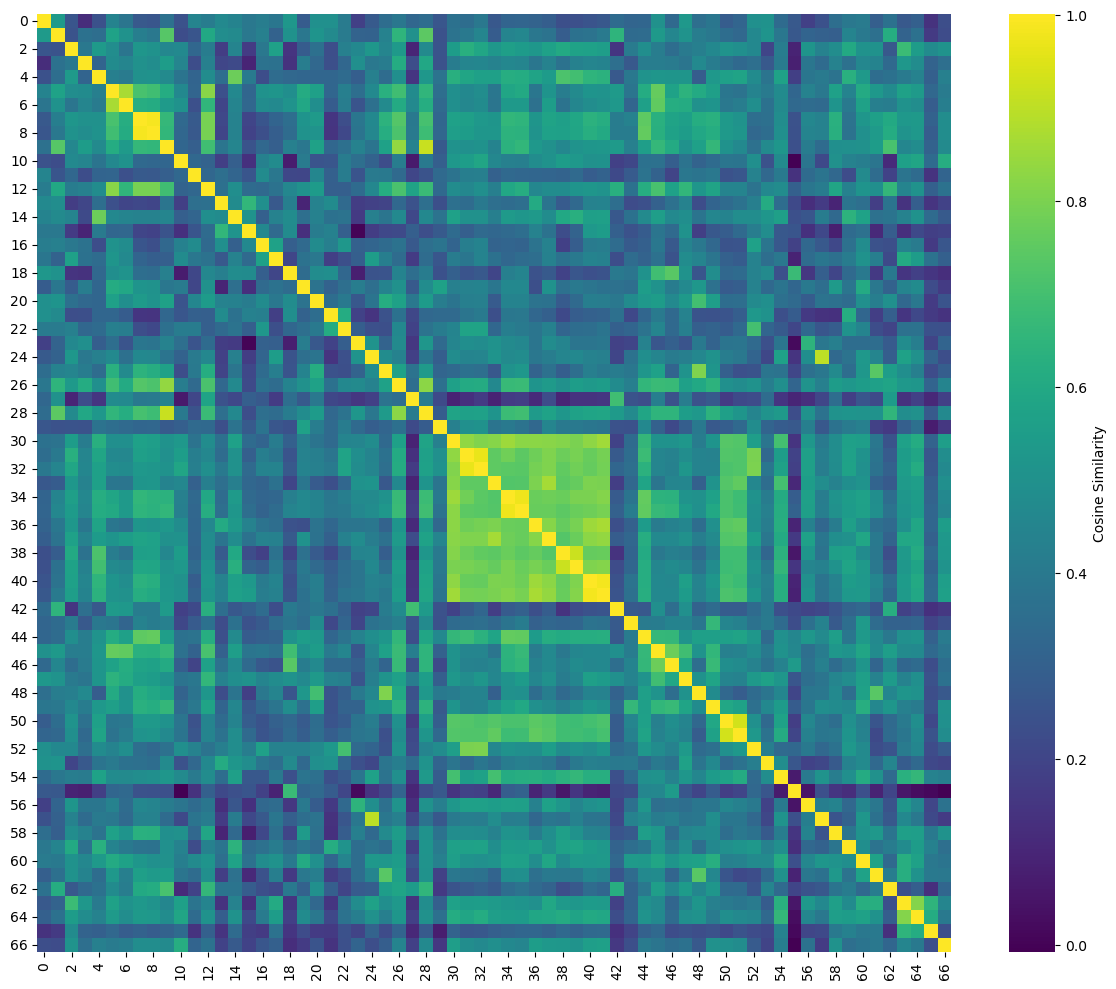

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

sns.heatmap(
    similarity_matrix,
    cmap='viridis',
    cbar_kws={'label': 'Cosine Similarity'}
)

plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
noms = embeddings_index['Nom'].tolist()
definitions = embeddings_index['Definition'].tolist()
source = embeddings_index['source'].tolist()
sim = similarity_matrix.copy()

# Mettre la diagonale à NaN pour l'exclure
np.fill_diagonal(sim, np.nan)

# Garder uniquement la partie supérieure
triu_indices = np.triu_indices_from(sim, k=1)

pairs = [
    (noms[i], noms[j], sim[i, j], definitions[i], definitions[j], source[i], source[j])
    for i, j in zip(*triu_indices)
]

pairs_df = pd.DataFrame(pairs, columns=["Nom_1", "Nom_2", "Similarity", "Definition_1", "Definition_2", "Source_1", "Source_2"])

# Trier par similarité
pairs_sorted = pairs_df.sort_values("Similarity", ascending=False)

# Top / Bottom 10
top_10 = pairs_sorted.head(10).reset_index(drop=True)

# Formater la similarité avec 4 décimales
pd.options.display.float_format = "{:.4f}".format

# Affichage propre
print(" 10 paires les plus similaires :\n")
display(top_10[['Nom_1', 'Nom_2', 'Similarity', 'Definition_1', 'Definition_2', 'Source_1', 'Source_2']])


 10 paires les plus similaires :



,Nom_1,Nom_2,Similarity,Definition_1,Definition_2,Source_1,Source_2
0,"Drêches de blé de distillerie, amidon < 7 %","Drêches de blé de distillerie, amidon > 7 %",0.9853,Coproduit déshydraté de la distillerie du blé ...,Coproduit déshydraté de la distillerie du blé ...,Donnees_IA,Donnees_IA
1,"Tourteau de tournesol, huile < 5 %, décortiqué","Tourteau de tournesol, huile < 5 %, non décort...",0.9812,Coproduit d'huilerie obtenu par extraction de ...,Coproduit d'huilerie obtenu par extraction de ...,Donnees_IA,Donnees_IA
2,"Tourteau de germes de maïs, huile < 5 %","Tourteau de germes de maïs, huile 5-20 %",0.9751,Coproduit d'huilerie obtenu par l'extraction d...,Coproduit d'huilerie obtenu par l'extraction d...,Donnees_IA,Donnees_IA
3,"Tourteau de colza, huile < 5 %","Tourteau de colza, huile 5-20 %",0.9680,Coproduit d'huilerie obtenu par extraction de ...,Coproduit d'huilerie obtenu par extraction de ...,Donnees_IA,Donnees_IA
4,"Son de riz, huile < 5 %","Son de riz, huile > 5 %",0.9299,Coproduit d'huilerie obtenu par extraction de ...,Coproduit d'huilerie obtenu par extraction de ...,Donnees_IA,Donnees_IA
5,"Tourteau de soja, huile < 5 %, 48 % protéine +...","Tourteau de soja, huile < 5 %, 50 % protéine +...",0.9191,Coproduit d'huilerie obtenu par extraction de ...,Coproduit d'huilerie obtenu par extraction de ...,Donnees_IA,Donnees_IA
6,Farine basse de blé tendre,Son de blé tendre,0.9143,Coproduit de meunerie du blé tendre (Triticum ...,Coproduit de meunerie du blé tendre (Triticum ...,Donnees_IA,Donnees_IA
7,Pulpe de betterave déshydratée,Mélasse de canne ou de betterave,0.8986,Coproduit déshydraté de la fabrication du sucr...,Coproduit sirupeux de la cristallisation du su...,Donnees_IA,Donnees_IA
8,Corn gluten feed,Corn gluten meal,0.8690,Coproduit de l'amidonnerie de maïs (Zea mays L...,Coproduit de l'amidonnerie de maïs (Zea mays L...,Donnees_IA,Donnees_IA
9,"Tourteau de lin, huile > 5 %","Tourteau de tournesol, huile < 5 %, non décort...",0.8674,Coproduit d'huilerie obtenu par extraction de ...,Coproduit d'huilerie obtenu par extraction de ...,Donnees_IA,Donnees_IA


In [15]:
import numpy as np

# similarity_matrix doit être NxN
# exclure la diagonale
np.fill_diagonal(similarity_matrix, np.nan)

# moyenne des similarités pour chaque embedding
mean_similarity = np.nanmean(similarity_matrix, axis=1)

# les embeddings avec la plus faible similarité moyenne sont les plus éloignés
least_similar_idx = np.argsort(mean_similarity)  # croissant

In [17]:
print("Top 5 embeddings les plus isolés :\n")
# Top 5 embeddings les plus isolés
for idx in least_similar_idx[:5]:
    print("Nom :", noms[idx])
    print("Definition :", definitions[idx])
    print("Source :", source[idx])
    print("Similarité moyenne :", mean_similarity[idx])
    print("-" * 50)

Top 5 embeddings les plus isolés :

Nom : Amidon de maïs
Definition : Amidon de maïs (Zea mays L.).
Source : Donnees_IA
Similarité moyenne : 0.20365284
--------------------------------------------------
Nom : Seigle 
Definition : Grain de seigle (Secale cereale L.).
Source : Donnees_IA
Similarité moyenne : 0.25378618
--------------------------------------------------
Nom : Poudre de lait entier
Definition : Lait entier déshydraté et réduit en poudre.
Source : Donnees_IA
Similarité moyenne : 0.2718091
--------------------------------------------------
Nom : Graine de tournesol 
Definition : Graine de tournesol (Helianthus annuus L.).
Source : Donnees_IA
Similarité moyenne : 0.29950154
--------------------------------------------------
Nom : Pois 
Definition : Graine de pois (Pisum sativum L.).
Source : Donnees_IA
Similarité moyenne : 0.30794734
--------------------------------------------------


In [18]:
print(" Top 5 embeddings les moins isolés :\n")
# Top 5 embeddings les moins isolés
for idx in least_similar_idx[-5:]:
    print("Nom :", noms[idx])
    print("Definition :", definitions[idx])
    print("Source :", source[idx])
    print("Similarité moyenne :", mean_similarity[idx])
    print("-" * 50)

 Top 5 embeddings les moins isolés :

Nom : Tourteau de tournesol, huile < 5 %, non décortiqué 
Definition : Coproduit d'huilerie obtenu par extraction de l'huile de graines de tournesol (Helianthus annuus L.) entières (non décortiquées). Ce produit a une faible teneur en huile résiduelle et a été déshuilé par pression mécanique suivie d'une extraction au solvant.
Source : Donnees_IA
Similarité moyenne : 0.5204841
--------------------------------------------------
Nom : Remoulage de blé tendre (tous) 
Definition : Coproduit de meunerie du blé tendre (Triticum aestivum L., également Triticum aestivum L. subsp. aestivum), constitué de fractions d'enveloppes, de fractions cellulosiques des cellules internes du grain et de fragments d'endosperme. Les remoulages commercialisés sont des mélanges de son et des autres issues en proportions variables. Ils sont généralement plus riches en amidon que le son, et moins riches en amidon que la farine basse. Les données correspondent à une moyenne de